<a href="https://colab.research.google.com/github/myller-silva/explications-anns-colab/blob/main/Explications_ANNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalações

In [332]:
!pip install cplex

In [333]:
!pip install docplex

In [334]:
# !pip install tensorflow

In [335]:
# !pip install matplotlib

# Importações

In [336]:
import os
import cplex
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
from cplex import infinity
import docplex.mp.model as mp
from typing import List, Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass
from statistics import mean, stdev
import matplotlib.patches as patches
from docplex.mp.constr import LinearConstraint

# Drive

## Montar o Google Drive

In [337]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/explications-anns'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Caminho para os arquivos no Google Drive

In [338]:
datasets_path = f'{base_path}/datasets'

In [339]:
resultados_path = f'{base_path}/resultados'

# Milp

## Fischetti

### Original

In [340]:
def codify_network_fischetti(
    mdl,
    layers,
    input_variables,
    auxiliary_variables,
    intermediate_variables,
    decision_variables,
    output_variables,
):
    output_bounds = []
    bounds = []

    for i in range(len(layers)):
        A = layers[i].get_weights()[0].T
        b = layers[i].bias.numpy()
        x = input_variables if i == 0 else intermediate_variables[i - 1]
        if i != len(layers) - 1:
            s = auxiliary_variables[i]
            a = decision_variables[i]
            y = intermediate_variables[i]
        else:
            y = output_variables

        for j in range(A.shape[0]):
            if i != len(layers) - 1:
                mdl.add_constraint(
                    A[j, :] @ x + b[j] == y[j] - s[j], ctname=f"c_{i}_{j}"
                )
                mdl.add_indicator(a[j], y[j] <= 0, 1)
                mdl.add_indicator(a[j], s[j] <= 0, 0)

                mdl.maximize(y[j])
                mdl.solve()
                ub_y = mdl.solution.get_objective_value()
                mdl.remove_objective()

                mdl.maximize(s[j])
                mdl.solve()
                ub_s = mdl.solution.get_objective_value()
                mdl.remove_objective()

                y[j].set_ub(ub_y)
                s[j].set_ub(ub_s)

                # retornar sem o sinal? [ub_s, ub_y]
                bounds.append([ub_s, ub_y])

            else:
                mdl.add_constraint(A[j, :] @ x + b[j] ==
                                   y[j], ctname=f"c_{i}_{j}")
                mdl.maximize(y[j])
                mdl.solve()
                ub = mdl.solution.get_objective_value()
                mdl.remove_objective()

                mdl.minimize(y[j])
                mdl.solve()
                lb = mdl.solution.get_objective_value()
                mdl.remove_objective()

                y[j].set_ub(ub)
                y[j].set_lb(lb)

                # todo: modificar para [-lb, ub]?
                output_bounds.append([lb, ub])

                bounds.append([lb, ub])

    return mdl, output_bounds, bounds

### Relaxado

In [341]:
def codify_network_fischetti_relaxed(
    mdl,
    layers,
    input_variables,
    auxiliary_variables,
    intermediate_variables,
    decision_variables,
    output_variables,
    output_bounds_binary_variables,
    bounds=[]
):
    output_bounds = []

    for i in range(len(layers)):  # para cada camada
        A = layers[i].get_weights()[0].T
        b = layers[i].bias.numpy()
        x = input_variables if i == 0 else intermediate_variables[i - 1]
        if i != len(layers) - 1:
            s = auxiliary_variables[i]
            a = decision_variables[i]
            y = intermediate_variables[i]
        else:
            y = output_variables

        for j in range(A.shape[0]):  # para cada neuronio da camada
            if i != len(layers) - 1:  # se não for a última camada(camada de saída)
                m_less, m_more = bounds[j]
                y[j].set_ub(m_less)
                s[j].set_ub(m_more)
                # m_less = -m_less # todo: modificar antes de verificar os valores?
                if m_more <= 0:
                    mdl.add_constraint(y[j] == 0)
                    continue

                if m_less >= 0:
                    mdl.add_constraint(A[j, :] @ x + b[j] == y[j])
                    continue

                if m_less < 0 and m_more > 0:
                    mdl.add_constraint(
                        A[j, :] @ x + b[j] == y[j] - s[j], ctname=f"c_{i}_{j}"
                    )
                    mdl.add_constraint(y[j] <= m_more * (1 - a[j]))
                    mdl.add_constraint(s[j] <= -m_less * a[j])
                    continue

            else:
                # todo: modificar para [-lb, ub]?
                lb, ub = output_bounds_binary_variables[j]
                y[j].set_lb(lb)
                y[j].set_ub(ub)
                output_bounds.append([lb, ub])

    return mdl, output_bounds

## Tjeng

In [342]:
def codify_network_tjeng(
    mdl,
    layers,
    input_variables,
    intermediate_variables,
    decision_variables,
    output_variables,
):
    output_bounds = []

    for i in range(len(layers)):
        A = layers[i].get_weights()[0].T
        b = layers[i].bias.numpy()
        x = input_variables if i == 0 else intermediate_variables[i - 1]
        if i != len(layers) - 1:
            a = decision_variables[i]
            y = intermediate_variables[i]
        else:
            y = output_variables

        for j in range(A.shape[0]):
            mdl.maximize(A[j, :] @ x + b[j])
            mdl.solve()
            ub = mdl.solution.get_objective_value()
            mdl.remove_objective()

            if ub <= 0 and i != len(layers) - 1:
                # print("ENTROU, o ub é negativo, logo y = 0")
                mdl.add_constraint(y[j] == 0, ctname=f"c_{i}_{j}")
                continue

            mdl.minimize(A[j, :] @ x + b[j])
            mdl.solve()
            lb = mdl.solution.get_objective_value()
            mdl.remove_objective()

            if lb >= 0 and i != len(layers) - 1:
                # print("ENTROU, o lb >= 0, logo y = Wx + b")
                mdl.add_constraint(A[j, :] @ x + b[j] ==
                                   y[j], ctname=f"c_{i}_{j}")
                continue

            if i != len(layers) - 1:
                mdl.add_constraint(y[j] <= A[j, :] @ x +
                                   b[j] - lb * (1 - a[j]))
                mdl.add_constraint(y[j] >= A[j, :] @ x + b[j])
                mdl.add_constraint(y[j] <= ub * a[j])

                # mdl.maximize(y[j])
                # mdl.solve()
                # ub_y = mdl.solution.get_objective_value()
                # mdl.remove_objective()
                # y[j].set_ub(ub_y)

            else:
                mdl.add_constraint(A[j, :] @ x + b[j] == y[j])
                # y[j].set_ub(ub)
                # y[j].set_lb(lb)
                output_bounds.append([lb, ub])

    return mdl, output_bounds

## Domain and Bounds

In [343]:
def get_domain_and_bounds_inputs(dataframe):
    domain = []
    bounds = []
    for column in dataframe.columns[:-1]:
        if len(dataframe[column].unique()) == 2:
            domain.append("B")
            bound_inf = dataframe[column].min()
            bound_sup = dataframe[column].max()
            bounds.append([bound_inf, bound_sup])
        elif np.any(
            dataframe[column].unique().astype(np.int64)
            != dataframe[column].unique().astype(np.float64)
        ):
            domain.append("C")
            bound_inf = dataframe[column].min()
            bound_sup = dataframe[column].max()
            bounds.append([bound_inf, bound_sup])
        else:
            domain.append("I")
            bound_inf = dataframe[column].min()
            bound_sup = dataframe[column].max()
            bounds.append([bound_inf, bound_sup])

    return domain, bounds

## Codify Network

**X ---- E**

x1 = 1 ∧ x2 = 3 ∧ F ∧ ¬E  
*INSATISFÁTIVEL*

x1 ≥ 0 ∧ x1 ≤ 100 ∧ x2 = 3 ∧ F ∧ ¬E  
*INSATISFÁTIVEL* → x1 não é relevante,  
*SATISFATÍVEL* → x1 é relevante


### Original

In [344]:
def codify_network(model, dataframe, method, relaxe_constraints):
    layers = model.layers
    num_features = layers[0].get_weights()[0].shape[0]
    mdl = mp.Model()

    domain_input, bounds_input = get_domain_and_bounds_inputs(dataframe)
    bounds_input = np.array(bounds_input)

    if relaxe_constraints:
        input_variables = mdl.continuous_var_list(
            num_features, lb=bounds_input[:,
                                          0], ub=bounds_input[:, 1], name="x"
        )
    else:
        input_variables = []
        for i in range(len(domain_input)):
            lb, ub = bounds_input[i]
            if domain_input[i] == "C":
                input_variables.append(
                    mdl.continuous_var(lb=lb, ub=ub, name=f"x_{i}"))
            elif domain_input[i] == "I":
                input_variables.append(
                    mdl.integer_var(lb=lb, ub=ub, name=f"x_{i}"))
            elif domain_input[i] == "B":
                input_variables.append(mdl.binary_var(name=f"x_{i}"))

    intermediate_variables = []
    auxiliary_variables = []
    decision_variables = []

    for i in range(len(layers) - 1):
        weights = layers[i].get_weights()[0]
        intermediate_variables.append(
            mdl.continuous_var_list(
                weights.shape[1], lb=0, name="y", key_format=f"_{i}_%s"
            )
        )

        if method == "fischetti":
            auxiliary_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], lb=0, name="s", key_format=f"_{i}_%s"
                )
            )

        if relaxe_constraints and method == "tjeng":
            decision_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )
        else:
            decision_variables.append(
                mdl.binary_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )

    output_variables = mdl.continuous_var_list(
        layers[-1].get_weights()[0].shape[1], lb=-infinity, name="o"
    )

    if method == "tjeng":
        mdl, output_bounds = codify_network_tjeng(
            mdl,
            layers,
            input_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
        )
    else:
        mdl, output_bounds, bounds = codify_network_fischetti(
            mdl,
            layers,
            input_variables,
            auxiliary_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
        )

    if relaxe_constraints:
        # Tighten domain of variables 'a'
        for i in decision_variables:
            for a in i:
                a.set_vartype("Integer")

        # Tighten domain of input variables
        for i, x in enumerate(input_variables):
            if domain_input[i] == "I":
                x.set_vartype("Integer")
            elif domain_input[i] == "B":
                x.set_vartype("Binary")
            elif domain_input[i] == "C":
                x.set_vartype("Continuous")

    return mdl, output_bounds, bounds


### Relaxado

In [345]:
def codify_network_relaxed(
    model, dataframe, method, relaxe_constraints, output_bounds_binary_variables, bounds
):
    layers = model.layers
    num_features = layers[0].get_weights()[0].shape[0]
    mdl = mp.Model()

    domain_input, bounds_input = get_domain_and_bounds_inputs(dataframe)
    bounds_input = np.array(bounds_input)

    if relaxe_constraints:
        input_variables = mdl.continuous_var_list(
            num_features, lb=bounds_input[:,0], ub=bounds_input[:, 1], name="x"
        )
    else:
        input_variables = []
        for i in range(len(domain_input)):
            lb, ub = bounds_input[i]
            input_variables.append(
                mdl.continuous_var(lb=lb, ub=ub, name=f"x_{i}"))

    intermediate_variables = []
    auxiliary_variables = []
    decision_variables = []

    for i in range(len(layers) - 1):
        weights = layers[i].get_weights()[0]
        intermediate_variables.append(
            mdl.continuous_var_list(
                weights.shape[1], lb=0, name="y", key_format=f"_{i}_%s"
            )
        )

        if method == "fischetti":
            auxiliary_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], lb=0, name="s", key_format=f"_{i}_%s"
                )
            )

        if relaxe_constraints and method == "tjeng":
            decision_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )
        else:
            # decision_variables.append(mdl.binary_var_list(weights.shape[1], name='a', lb=0, ub=1, key_format=f"_{i}_%s"))
            decision_variables.append(
                mdl.continuous_var_list(
                    weights.shape[1], name="a", lb=0, ub=1, key_format=f"_{i}_%s"
                )
            )

    output_variables = mdl.continuous_var_list(
        layers[-1].get_weights()[0].shape[1], lb=-infinity, name="o"
    )

    if method == "tjeng":
        mdl, output_bounds = codify_network_tjeng(
            mdl,
            layers,
            input_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
        )
    else:
        mdl, output_bounds = codify_network_fischetti_relaxed(
            mdl,
            layers,
            input_variables,
            auxiliary_variables,
            intermediate_variables,
            decision_variables,
            output_variables,
            output_bounds_binary_variables,
            bounds=bounds
        )

    if relaxe_constraints:
        # Tighten domain of variables 'a'
        for i in decision_variables:
            for a in i:
                a.set_vartype("Continuous")

        # Tighten domain of input variables
        for i, x in enumerate(input_variables):
            x.set_vartype("Continuous")

    return mdl, output_bounds


# Teste

## Insert Outputs

In [346]:
def insert_output_constraints_fischetti(
    mdl, output_variables, network_output, binary_variables
):
    # print(binary_variables)
    variable_output = output_variables[network_output]
    aux_var = 0

    for i, output in enumerate(output_variables):
        if i != network_output:
            p = binary_variables[aux_var]
            aux_var += 1
            mdl.add_indicator(p, variable_output <= output, 1)

    return mdl

def insert_output_constraints_tjeng(
    mdl, output_variables, network_output, binary_variables, output_bounds
):
    variable_output = output_variables[network_output]
    upper_bounds_diffs = (
        output_bounds[network_output][1] - np.array(output_bounds)[:, 0]
    )  # Output i: oi - oj <= u1 = ui - lj
    aux_var = 0

    for i, output in enumerate(output_variables):
        if i != network_output:
            ub = upper_bounds_diffs[i]
            z = binary_variables[aux_var]
            mdl.add_constraint(variable_output - output - ub * (1 - z) <= 0)
            aux_var += 1

    return mdl


## Explicações

### Original

In [347]:
def get_minimal_explanation(
    mdl,
    network_input,
    network_output,
    n_classes,
    method,
    output_bounds=None,
    initial_explanation=None,
) -> Tuple[List[LinearConstraint], mp.Model]:
    assert not (
        method == "tjeng" and output_bounds == None
    ), "If the method tjeng is chosen, output_bounds must be passed."

    output_variables = [mdl.get_var_by_name(f"o_{i}") for i in range(n_classes)]

    if initial_explanation is None:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == feature.numpy()
                for i, feature in enumerate(network_input[0])
            ],
            names="input",
        )
    else:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == network_input[0][i].numpy()
                for i in initial_explanation
            ],
            names="input",
        )

    binary_variables = mdl.binary_var_list(n_classes - 1, name="b")
    mdl.add_constraint(mdl.sum(binary_variables) >= 1)
    # todo: salvar modelo durante a explicação

    if method == "tjeng":
        mdl = insert_output_constraints_tjeng(
            mdl, output_variables, network_output, binary_variables, output_bounds
        )
    else:
        mdl = insert_output_constraints_fischetti(
            mdl, output_variables, network_output, binary_variables
        )

    for constraint in input_constraints:
        mdl.remove_constraint(constraint)

        mdl.solve(log_output=False)
        if mdl.solution is not None:
            mdl.add_constraint(constraint)

    inputs = mdl.find_matching_linear_constraints("input")
    return (inputs, mdl)
    # return mdl.find_matching_linear_constraints("input")

### Relaxado

In [348]:
def get_explanation_relaxed(
    mdl: mp.Model,
    network_input,
    network_output,
    n_classes,
    method,
    output_bounds=None,
    initial_explanation=None,
    delta=0.1,
) -> Tuple[List[LinearConstraint], mp.Model]:
    # todo: output_bounds só é relevante se o metodo for tjeng
    assert not (
        method == "tjeng" and output_bounds == None
    ), "If the method tjeng is chosen, output_bounds must be passed."

    output_variables = [mdl.get_var_by_name(f"o_{i}") for i in range(n_classes)]

    if initial_explanation is None:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == feature.numpy()
                for i, feature in enumerate(network_input[0])
            ],
            names="input",
        )
    else:
        input_constraints = mdl.add_constraints(
            [
                mdl.get_var_by_name(f"x_{i}") == network_input[0][i].numpy()
                for i in initial_explanation
            ],
            names="input",
        )

    binary_variables = mdl.binary_var_list(n_classes - 1, name="b")
    mdl.add_constraint(mdl.sum(binary_variables) >= 1)
    # todo: salvar modelo durante a explicação

    if method == "tjeng":
        mdl = insert_output_constraints_tjeng(
            mdl, output_variables, network_output, binary_variables, output_bounds
        )

    else:
        mdl = insert_output_constraints_fischetti(
            mdl, output_variables, network_output, binary_variables
        )

    for constraint in input_constraints:
        mdl.remove_constraint(constraint)

        x = constraint.get_left_expr()
        v = constraint.get_right_expr()

        constraint_left = mdl.add_constraint(v - delta <= x)
        constraint_right = mdl.add_constraint(x <= v + delta)

        mdl.solve(log_output=False)
        if mdl.solution is not None:
            mdl.add_constraint(constraint)
            mdl.remove_constraint(constraint_left)
            mdl.remove_constraint(constraint_right)

    inputs = mdl.find_matching_linear_constraints("input")
    return (inputs, mdl)

# Main

## Gerar Rede Neural

In [349]:
def gerar_rede(dir_path: str, num_classes: int, n_neurons: int, n_hidden_layers: int):
    data_train = pd.read_csv(dir_path + "\\" + "train.csv").to_numpy()
    data_test = pd.read_csv(dir_path + "\\" + "test.csv").to_numpy()

    x_train, y_train = data_train[:, :-1], data_train[:, -1]
    x_test, y_test = data_test[:, :-1], data_test[:, -1]

    y_train_ohe = tf.keras.utils.to_categorical(
        y_train, num_classes=num_classes)
    y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=[x_train.shape[1]]),
        ]
    )

    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model_path = os.path.join(
        dir_path, "models", f"model_{n_hidden_layers}layers_{n_neurons}neurons.h5"
    )

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    ck = tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor="val_accuracy", save_best_only=True
    )

    start = time()
    model.fit(
        x_train,
        y_train_ohe,
        batch_size=4,
        epochs=100,
        validation_data=(x_test, y_test_ohe),
        verbose=2,
        callbacks=[ck, es],
    )
    print(f"Tempo de Treinamento: {time()-start}")

    # salvar modelo
    model = tf.keras.models.load_model(model_path)

    # avaliar modelo com os dados de treinamento
    print("Resultado Treinamento")
    model.evaluate(x_train, y_train_ohe, verbose=2)

    # avaliar modelo com os dados de teste
    print("Resultado Teste")
    model.evaluate(x_test, y_test_ohe, verbose=2)

In [350]:
def gerar_rede_com_dataset_iris(n_neurons=20, n_hidden_layers=1):
    dir_path = "datasets\\iris"
    num_classes = 3
    gerar_rede(dir_path, num_classes, n_neurons, n_hidden_layers)


def gerar_rede_com_dataset_digits(n_neurons=20, n_hidden_layers=1):
    dir_path = "datasets\\digits"
    num_classes = 10
    gerar_rede(dir_path, num_classes, n_neurons, n_hidden_layers)


def gerar_rede_com_dataset_wine(n_neurons=20, n_hidden_layers=1):
    dir_path = "datasets\\wine"
    num_classes = 10
    gerar_rede(dir_path, num_classes, n_neurons, n_hidden_layers)

## Explicar Instância

In [351]:
def explain_instance(
    initial_network,
    configuration: dict,
    instance_index: int,
    data: pd.DataFrame,
    model_h5,
    n_classes
) -> Tuple[List[LinearConstraint], mp.Model]:
    method = configuration["method"]
    (
        mdl_milp_with_binary_variable,
        output_bounds_binary_variables,
        bounds,
    ) = initial_network
    network_input = data.iloc[instance_index, :-1]
    # print(network_input)  # network_input = instance
    network_input = tf.reshape(tf.constant(network_input), (1, -1))
    network_output = model_h5.predict(tf.constant(network_input))[0]
    network_output = tf.argmax(network_output)
    mdl_aux = mdl_milp_with_binary_variable.clone()
    (explanation, model) = get_minimal_explanation(
        mdl_aux,
        network_input,
        network_output,
        n_classes=n_classes,
        method=method,
        output_bounds=output_bounds_binary_variables,
    )

    return (explanation, model)

In [352]:
def explain_instance_relaxed(
    initial_network,
    initial_network_relaxed,
    configuration: dict,
    instance_index: int,
    data: pd.DataFrame,
    model_h5,
    n_classes,
    delta=1,
) -> Tuple[List[LinearConstraint], mp.Model]:
    method = configuration["method"]
    (
        mdl_milp_with_binary_variable,
        output_bounds_binary_variables,
        bounds,
    ) = initial_network

    model_milp_relaxed, output_bounds_relaxed = initial_network_relaxed
    network_input = data.iloc[instance_index, :-1]
    # print(network_input)  # network_input = instance
    network_input = tf.reshape(tf.constant(network_input), (1, -1))
    network_output = model_h5.predict(tf.constant(network_input))[0]
    network_output = tf.argmax(network_output)

    mdl_aux = model_milp_relaxed.clone()

    (explanation, model) = get_explanation_relaxed(
        mdl_aux,
        network_input,
        network_output,
        n_classes=n_classes,
        method=method,
        output_bounds=output_bounds_binary_variables,
        delta=delta,
    )

    return (explanation, model)

# Benchmark

## Datasets

In [353]:
@dataclass
class Dataset:
    dir_path: str
    model: str
    n_classes: int

datasets: List[Dataset] = [
    Dataset(
        dir_path=f"{datasets_path}/digits",
        model="models/model_0layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path=f"{datasets_path}/digits",
        model="models/model_1layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path=f"{datasets_path}/digits",
        model="models/model_2layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path=f"{datasets_path}/digits",
        model="models/model_3layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path=f"{datasets_path}/digits",
        model="models/model_4layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path=f"{datasets_path}/digits",
        model="models/model_5layers_20neurons.h5",
        n_classes=10,
    ),
    Dataset(
        dir_path=f"{datasets_path}/iris",
        model="models/model_1layers_20neurons.h5",
        n_classes=3,
    ),
    Dataset(
        dir_path=f"{datasets_path}/iris",
        model="models/model_6layers_20neurons.h5",
        n_classes=3,
    ),
]

configurations = [{"method": "fischetti", "relaxe_constraints": True}]

## Configurações

In [354]:
def read_dataset(dir_path, model_h5_file):
  data_test = pd.read_csv(f"{dir_path}/test.csv")
  data_train = pd.read_csv(f"{dir_path}/train.csv")
  data = data_train._append(data_test)

  model_h5 = tf.keras.models.load_model(f"{dir_path}/{model_h5_file}")
  return (data, model_h5)

In [355]:
dataset_index = 1
dir_path, n_classes, model_h5_file = (
    datasets[dataset_index].dir_path,
    datasets[dataset_index].n_classes,
    datasets[dataset_index].model,
)

configuration_index = 0
method = configurations[configuration_index]["method"]
relaxe_constraints = configurations[configuration_index]["relaxe_constraints"]
(data, model_h5) = read_dataset(dir_path, model_h5_file)

## Diretório dos resultados


In [356]:
def create_results_directory(dir_path:str, model_h5_file:str)->str:
  file_name_model = (f"{dir_path}/{model_h5_file}")
  file_name_model_result = (f"{dir_path}/results/{model_h5_file}")
  if not os.path.exists(file_name_model_result):
      os.makedirs(file_name_model_result)
  return file_name_model_result

In [357]:
file_result = create_results_directory(dir_path, model_h5_file)

In [358]:
# data.to_csv(f"{file_name_model_result}/result3.csv")

## Modelos MILP

### Modelo MILP Original

In [359]:
# todo: pegar output_bounds_binary_variables e bounds a partir do modelo já pronto, ao inves de salvar durante a modelagem
# todo: modificar para verificar se o modelo já está codificado antes de codificar(ou seja, ler o arquivo .lp)
initial_network = codify_network(model_h5, data, method, relaxe_constraints)
(
    mdl_milp_with_binary_variable,
    output_bounds_binary_variables,
    bounds,
) = initial_network

### Modelo MILP Relaxado

In [360]:
initial_network_relaxed = codify_network_relaxed(
    model_h5,
    data,
    method,
    relaxe_constraints,
    output_bounds_binary_variables,
    bounds=bounds,
)

### Salvar Modelos MILPs


In [361]:
def export_milp_as_lp(mdl: mp.Model, file: str):
  mdl.export_as_lp(f"{file}")


#### Salvar modelo MILP original


In [362]:
export_milp_as_lp(mdl_milp_with_binary_variable, f'{file_result}/original')

#### Salvar modelo MILP relaxado

In [363]:
(mdl_relaxed, output_bounds_relaxed) = initial_network_relaxed
export_milp_as_lp(mdl_relaxed, f'{file_result}/relaxed')

### Abrir Modelos MILPs

#### Abrir Modelo MILP Original

In [364]:
def read_cplex_model(file: str):
  return cplex.Cplex(file)

In [365]:
file_path_lp = f"{file_result}/original.lp"
# model_read = cplex.Cplex(caminho_do_arquivo_lp)
model_read = read_cplex_model(file_path_lp)

In [366]:
var_names = model_read.variables.get_names()
var_names_filtered = [nome for nome in var_names if nome.startswith('')]
print(var_names_filtered.__str__())


['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'y_0_0', 's_0_0', 'y_0_1', 's_0_1', 'y_0_2', 's_0_2', 'y_0_3', 's_0_3', 'y_0_4', 's_0_4', 'y_0_5', 's_0_5', 'y_0_6', 's_0_6', 'y_0_7', 's_0_7', 'y_0_8', 's_0_8', 'y_0_9', 's_0_9', 'y_0_10', 's_0_10', 'y_0_11', 's_0_11', 'y_0_12', 's_0_12', 'y_0_13', 's_0_13', 'y_0_14', 's_0_14', 'y_0_15', 's_0_15', 'y_0_16', 's_0_16', 'y_0_17', 's_0_17', 'y_0_18', 's_0_18', 'y_0_19', 's_0_19', 'o_0', 'o_1', 'o_2', 'o_3', 'o_4', 'o_5', 'o_6', 'o_7', 'o_8', 'o_9', 'a_0_0', 'a_0_1', 'a_0_2', 'a_0_3', 'a_0_4', 'a

#### Abrir Modelo MILP Relaxado

In [367]:
# todo: verificar se o codify está criando as variaveis "o's" corretamente
path_file_lp_relaxed = f"{file_result}/relaxed.lp"
model_relaxed_read = read_cplex_model(path_file_lp_relaxed)

Warning, line 534: Name 's_0_0' does not exist.
Warning, line 535: Name 's_0_1' does not exist.
Warning, line 536: Name 's_0_2' does not exist.
Warning, line 537: Name 's_0_3' does not exist.
Warning, line 538: Name 's_0_4' does not exist.
Warning, line 539: Name 's_0_5' does not exist.
Warning, line 540: Name 's_0_6' does not exist.
Warning, line 541: Name 's_0_7' does not exist.
Warning, line 542: Name 's_0_8' does not exist.
Warning, line 543: Name 's_0_9' does not exist.
Warning, line 544: Name 's_0_10' does not exist.
Warning, line 545: Name 's_0_11' does not exist.
Warning, line 546: Name 's_0_12' does not exist.
Warning, line 547: Name 's_0_13' does not exist.
Warning, line 548: Name 's_0_14' does not exist.
Warning, line 549: Name 's_0_15' does not exist.
Warning, line 550: Name 's_0_16' does not exist.
Warning, line 551: Name 's_0_17' does not exist.
Warning, line 552: Name 's_0_18' does not exist.
Warning, line 553: Name 's_0_19' does not exist.
30 name warnings not printed.


In [368]:
var_names_relaxed = model_relaxed_read.variables.get_names()
var_names_relaxed_filtered = [nome for nome in var_names_relaxed if nome.startswith('')]
print(var_names_relaxed_filtered.__str__())

['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7', 'y_0_8', 'y_0_9', 'y_0_10', 'y_0_11', 'y_0_12', 'y_0_13', 'y_0_14', 'y_0_15', 'y_0_16', 'y_0_17', 'y_0_18', 'y_0_19']


## Executar Benchmark

In [369]:
def convert_string_to_pixel(pixel_str: str, matrix_size: tuple[int, int]) -> tuple[int, int]:
    # Remover o prefixo "x_"
    pixel_number = int(pixel_str.split("_")[1])
    # Obter as dimensões da matriz
    rows, cols = matrix_size
    # Calcular as coordenadas do pixel
    row_index = pixel_number // rows
    col_index = pixel_number % cols

    return row_index, col_index

def get_coordinates_from_explanation(
  explanation: list[LinearConstraint],
  matrix_size: tuple[int, int],
) -> list[tuple[int, int]]:
    coordinates = []
    for constraint in explanation:
        # Extrair coordenadas da variável associada à restrição linear
        variable_name = constraint.left_expr.name
        x, y = convert_string_to_pixel(variable_name, matrix_size)
        coordinates.append((x, y))
    return coordinates

In [370]:
def benchmark_instance(
    path: str, instance_index: int, delta=0.1, use_milp_original=False
):
    print(instance_index)
    directory = f"{path}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_results = f"{directory}/df.csv"
    if os.path.exists(file_results):
        resultados = pd.read_csv(file_results)
    else:
        resultados = pd.DataFrame(
            columns=[
                "instance_index",
                "tempo_original",
                "tempo_relaxado",
                "tempo_relaxado_global",
                "len_original",
                "len_relaxado",
                "len_relaxado_global",
                "delta",
                "explanation",
                "explanation_relaxed",
                "explanation_relaxed_global",
            ]
        )

    (
        tempo_original,
        len_original,
        explanation
    ) = [None] * 3
    if use_milp_original:
        # explain_instance original
        start_time = time()
        (explanation, model_milp_original) = explain_instance(
            initial_network = initial_network,
            configuration = configurations[0],
            instance_index = instance_index,
            data = data,
            model_h5 = model_h5,
            n_classes = n_classes
        )
        end_time = time()
        tempo_original = end_time - start_time
        len_original = len(explanation)

    # explain_instance_relaxed local
    start_time = time()
    (explanation_relaxed, model_milp_relaxed) = explain_instance_relaxed(
        initial_network = initial_network,
        initial_network_relaxed = initial_network_relaxed,
        configuration = configurations[0],
        instance_index = instance_index,
        data = data,
        model_h5 = model_h5,
        n_classes = n_classes,
        delta=delta,
    )

    end_time = time()
    tempo_relaxado = end_time - start_time
    len_relaxado = len(explanation_relaxed)

    # explain_instance_relaxed global
    start_time = time()
    (explanation_relaxed_global, model_milp_relaxed_global) = explain_instance_relaxed(
        initial_network = initial_network,
        initial_network_relaxed = initial_network_relaxed,
        configuration = configurations[0], #todo: modificar para passar o metodo diretamente
        instance_index = instance_index,
        data = data,
        model_h5 = model_h5,
        n_classes = n_classes,
        delta=1,  # global
    )

    end_time = time()
    tempo_relaxado_global = end_time - start_time
    len_relaxado_global = len(explanation_relaxed_global)

    resultados.loc[len(resultados)] = [
        instance_index,
        tempo_original,
        tempo_relaxado,
        tempo_relaxado_global,
        len_original,
        len_relaxado,
        len_relaxado_global,
        delta,
        get_coordinates_from_explanation(explanation, (8, 8)) if explanation is not None else None,
        get_coordinates_from_explanation(explanation_relaxed, (8, 8)),
        get_coordinates_from_explanation(explanation_relaxed_global, (8, 8)),
    ]

    # exportar modelos
    export_milp_as_lp(model_milp_original, f"{directory}/original_after")
    export_milp_as_lp(model_milp_original, f"{directory}/relaxed_after")
    export_milp_as_lp(model_milp_original, f"{directory}/relaxed_global_after")

    # salvar
    resultados.to_csv(file_results, index=False)
    return [explanation, explanation_relaxed, explanation_relaxed_global]

In [378]:
path = f"{file_result}"
delta = 0.7
for index in range(0, 9):
  # index = 6
  r = benchmark_instance(
    path=path,
    instance_index=index,
    delta=delta,
    use_milp_original=True
    )

0
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 21ms/step
2
1/1 [==============================] - 0s 24ms/step
3
1/1 [==============================] - 0s 20ms/step
4
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 21ms/step
6
1/1 [==============================] - 0s 24ms/step
7
1/1 [==============================] - 0s 21ms/step
8
1/1 [==============================] - 0s 21ms/step


In [379]:
result_df = pd.read_csv(f'{file_result}/df.csv')

In [380]:
result_df[["instance_index",	"tempo_original",	"tempo_relaxado",	"tempo_relaxado_global",	"len_original",	"len_relaxado",	"len_relaxado_global",	"delta"]]

,instance_index,tempo_original,tempo_relaxado,tempo_relaxado_global,len_original,len_relaxado,len_relaxado_global,delta
0,0,1.824829,0.647120,0.770094,43,35,33,0.7
1,1,3.344312,0.586576,0.547331,43,46,42,0.7
2,2,1.476407,0.530838,0.532079,44,26,29,0.7
3,3,1.379243,0.500143,0.490699,44,32,33,0.7
4,4,1.609786,0.538788,0.704136,46,29,35,0.7
5,5,2.976138,0.553387,0.547208,44,39,40,0.7
6,6,1.556840,0.547644,0.570123,44,34,33,0.7
7,7,2.338710,0.519520,0.539383,40,32,40,0.7
8,8,1.493572,0.500194,0.676789,40,37,41,0.7


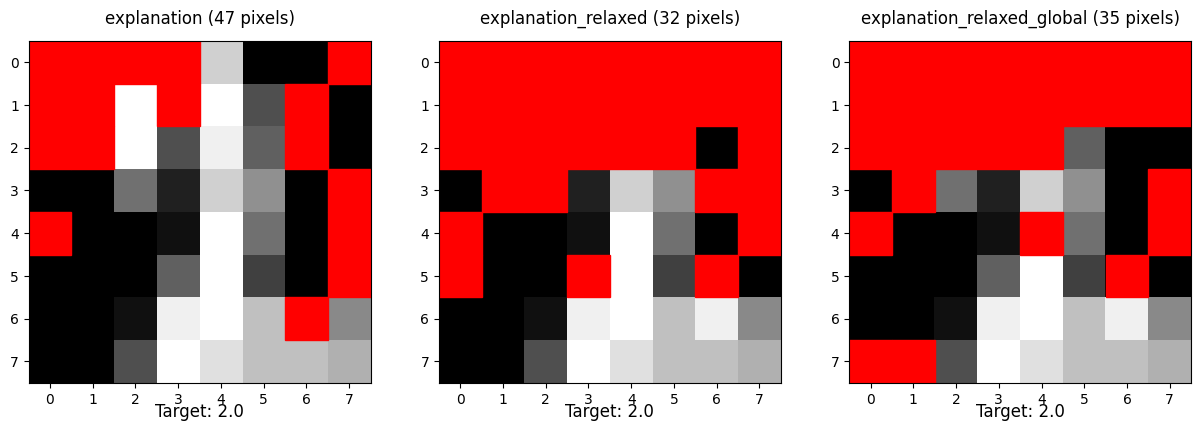

In [374]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def string_to_list(string):
    return ast.literal_eval(string)

def show_image_with_explanation(ax, df: pd.DataFrame, instancia_index: int, explanation: list, explanation_name: str):
    instancia_values = df.iloc[instancia_index, :-1].values
    instancia = instancia_values.reshape(8, 8)

    ax.imshow(instancia, cmap="gray")

    target = df.iloc[instancia_index, -1]
    # Adicionar texto com o alvo
    ax.text(
        0.5, -0.1,
        f"Target: {target}",
        fontsize=12,
        ha="center",
        transform=ax.transAxes
    )

    # Pintar retângulos vermelhos nos pixels não explicados
    for i in range(8):
        for j in range(8):
            if (i, j) not in explanation:
                rect = patches.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor="r", facecolor="r", alpha=1
                )
                ax.add_patch(rect)

    # Adicionar texto com o nome da explicação e quantidade de pixels
    ax.text(
        0.5, 1.05,
        f"{explanation_name} ({len(explanation)} pixels)",
        fontsize=12,
        ha="center",
        transform=ax.transAxes
    )

# Criar uma figura com 1 linha e 3 colunas para exibir os subplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Chamar a função show_image_with_explanation para cada subplot
index = 8
explanation_names = ["explanation", "explanation_relaxed", "explanation_relaxed_global"]
for i, ax in enumerate(axs):
    explanation_name = explanation_names[i]
    show_image_with_explanation(
        ax, data, index, string_to_list(result_df.iloc[index][explanation_name]), explanation_name
    )

plt.show()


In [375]:
explanation_relaxed = string_to_list(result_df.iloc[index]["explanation_relaxed"])
explanation_relaxed_global = string_to_list(result_df.iloc[index]["explanation_relaxed_global"])

elements_only_in_relaxed = set(explanation_relaxed) - set(explanation_relaxed_global)

print("Elementos apenas em explanation_relaxed:", elements_only_in_relaxed)


Elementos apenas em explanation_relaxed: {(4, 4), (7, 0), (7, 1)}


In [376]:
explanation = string_to_list(result_df.iloc[index]["explanation"])
explanation_relaxed_global = string_to_list(result_df.iloc[index]["explanation_relaxed_global"])

elements_only_in_relaxed = set(explanation) - set(explanation_relaxed_global)

print("Elementos apenas em explanation:", elements_only_in_relaxed)


Elementos apenas em explanation: {(4, 4), (2, 4), (1, 2), (7, 1), (0, 4), (1, 5), (3, 1), (7, 0), (1, 4), (0, 6), (2, 3), (1, 7), (5, 6), (0, 5), (2, 2)}
